# Identify Question Pairs

### Motivação

Um dos desafios conhecidos dos chatbots é o fato de diferentes pessoas escreverem as mesmas sentenças de maneiras distintas. Este fato acarreta em dois grandes problemas, o primeiro é a necessidade de um grande volume de informações e exemplos, para tentar cobrir o máximo formas distintas para uma mesma pergunta, e a frustração do usuário que não consegue ser entendido pelo fato de ter escrito de uma maneira diferente da esperada. Visto isso meu objetivo com este trabalho é reconhecer casos de perguntas com o mesmo propósito.


<img src="badchatbot.png">

In [1]:
import multiprocessing
import os
import re
import nltk
import gensim.models.word2vec as word2vec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization

%matplotlib inline

Using TensorFlow backend.
/home/pedro/anaconda3/envs/condaVENV/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/pedro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pedro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('resources/quora_duplicate_questions.tsv', sep='\t')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [9]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


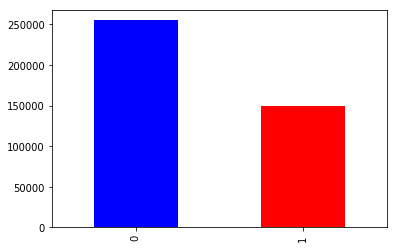

In [11]:
df['is_duplicate'].value_counts().plot(kind='bar', color=['blue', 'red'])

## Word2Vec Model

O word2vec vetoriza cada palavra do corpus levando em consideração o contexto no qual é usada, deste modo palavras de contexto parecidos são espacialmente próximas

<img src="linear-relationships.png",width=800,height=600>

In [3]:
num_features = 300

In [41]:
corpus_raw = u""

for question in df['question1']:
    corpus_raw += str(question)
    
for question in df['question2']:
    corpus_raw += str(question)

In [42]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

raw_sentences = tokenizer.tokenize(corpus_raw)

In [43]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [44]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [45]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 8,974,341 tokens


In [46]:
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3

word2vec_model = word2vec.Word2Vec(
    sg=1,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

word2vec_model.build_vocab(sentences)

In [47]:
print("Word2Vec vocabulary length:", word2vec_model.corpus_count)

Word2Vec vocabulary length: 96440


In [48]:
word2vec_model.train(sentences=sentences, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.iter)

32409518

In [49]:
if not os.path.exists("trained"):
    os.makedirs("trained")

word2vec_model.save(os.path.join("trained", "word2vec.w2v"))

## Load Word2Vec Model

Caso já exista um modelo localmente, não existe a necessidade de um novo treinamento

In [ ]:
num_features = 300

In [4]:
word2vec_model = word2vec.Word2Vec.load(os.path.join("trained", "word2vec.w2v"))

In [51]:
word2vec_model.most_similar("religion")

[('Hinduism', 0.6152031421661377),
 ('Christianity', 0.5793802738189697),
 ('atheism', 0.5729184150695801),
 ('Abrahamic', 0.5699256658554077),
 ('disproving', 0.5685814619064331),
 ('Islam', 0.5668637156486511),
 ('Buddhists', 0.5447323322296143),
 ('monotheistic', 0.5379245281219482),
 ('lame', 0.5344815850257874),
 ('religions', 0.5328493714332581)]

## Build LSTM Model


A LSTM foi utilizada por 2 principais motivos. O primeiro diz respeito ao fato de LSTM ser uma RNN, o que permite uma entrada de tamanho variável, o que é perfeito para tratar perguntas de tamanhos diferentes. O segundo motivo, e mais importante, é o fato da LSTM guardar uma memória do que foi previamente passado como input, ou seja, a ordem das palavras importa, ‘cachorro mordeu o homem’ não é igual a ‘homem mordeu o cachorro’.

<img src="lstm.png">

In [5]:
max_words = 200000
max_sequence_length = 300
batch_size = 100
num_lstm = 50

In [6]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['question1'].astype(str) + df['question2'].astype(str))

sequence1 = tokenizer.texts_to_sequences(df['question1'].astype(str))
sequence2 = tokenizer.texts_to_sequences(df['question2'].astype(str))

In [7]:
data1 = pad_sequences(sequences=sequence1, maxlen=max_sequence_length)
data2 = pad_sequences(sequences=sequence2, maxlen=max_sequence_length)

In [8]:
num_words = min(max_words, len(tokenizer.word_index))+1

embedding_matrix = np.zeros((num_words, num_features))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv.vocab:
        embedding_matrix[i] = word2vec_model.wv[word]

In [9]:
embedding_layer = Embedding(num_words, num_features, weights=[embedding_matrix], 
                    trainable=False, input_length=max_sequence_length)

lstm_layer = LSTM(num_lstm, dropout=0.2, recurrent_dropout=0.2)

input1 = Input(shape=(max_sequence_length,), dtype='int32')
embedded1 = embedding_layer(input1)
lstm1 = lstm_layer(embedded1)

input2 = Input(shape=(max_sequence_length,), dtype='int32')
embedded2 = embedding_layer(input2)
lstm2 = lstm_layer(embedded2)

merged = concatenate([lstm1, lstm2])
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

In [10]:
model = Model(inputs=[input1, input2], outputs=preds)

In [21]:
temp1 = pd.DataFrame(data1)
temp2 = pd.DataFrame(data2)
temp = pd.concat([temp1, temp2], axis=1)
temp['Y'] = df['is_duplicate']

X = temp.iloc[:, :-1].values
Y = temp.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [33]:
X_test[:,300:].shape

(80858, 300)

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
    model.fit([X_train[:,:300], X_train[:,300:]], Y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=([X_test[:,:300], X_test[:,300:]], Y_test))

Train on 323432 samples, validate on 80858 samples
Epoch 1/15
323432/323432 [==============================] - 4074s 13ms/step - loss: 0.5137 - acc: 0.7488 - val_loss: 0.4987 - val_acc: 0.7588
Epoch 2/15
323432/323432 [==============================] - 4056s 13ms/step - loss: 0.4992 - acc: 0.7586 - val_loss: 0.4898 - val_acc: 0.7657
Epoch 3/15
323432/323432 [==============================] - 4048s 13ms/step - loss: 0.4902 - acc: 0.7647 - val_loss: 0.4810 - val_acc: 0.7719
Epoch 4/15
323432/323432 [==============================] - 4075s 13ms/step - loss: 0.4813 - acc: 0.7693 - val_loss: 0.4800 - val_acc: 0.7722
Epoch 5/15
323432/323432 [==============================] - 8915s 28ms/step - loss: 0.4757 - acc: 0.7740 - val_loss: 0.4734 - val_acc: 0.7778
Epoch 6/15
323432/323432 [==============================] - 4333s 13ms/step - loss: 0.4702 - acc: 0.7771 - val_loss: 0.4748 - val_acc: 0.7772
Epoch 7/15
323432/323432 [==============================] - 10343s 32ms/step - loss: 0.4653 - acc